In [40]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

from collections import defaultdict, namedtuple
from sklearn.metrics import accuracy_score, f1_score

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEVICE

device(type='cuda')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
data_df = pd.read_csv('IMDB Dataset.csv')

In [6]:
MAX_LEN = 512
PAD_INDEX = 0
BATCH_SIZE = 16

In [7]:
def tokenize(text):
    token = torch.tensor(tokenizer(text, truncation=True)['input_ids'])
    # колхозные паддинги
    padded_token = torch.cat((token, torch.zeros(MAX_LEN - token.shape[0])), 0)
    return padded_token

In [8]:
data = list(zip(
    list(map(tokenize, data_df['review'])),
    list(map(lambda sent: 0 if sent == 'negative' else 1, data_df['sentiment'])),
))

In [49]:
train = data[:32]#[:-5000]
print(len(train))
test = data[-16:]#[-5000:]
print(len(test))

32
16


In [50]:
# проверяем, что паддинги сработали корректно
all(map(lambda t: t[0].shape[0] == MAX_LEN, train))

True

In [51]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE)

In [52]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [71]:
model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

In [72]:
# нам не нужно, чтобы берт обучался
for p in model.parameters():
    p.requires_grad = False

In [73]:
criterion = torch.nn.CrossEntropyLoss()
# [размерность_выхода_берта, количество_классов]
classifier = torch.nn.Linear(768, 2).to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

In [ ]:
metrics = namedtuple(
    'M', ['train', 'test']
)(defaultdict(list), defaultdict(list))



for e in range(50):
    print(f'Epoch: {e}')
    for x, y in tqdm(train_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        model.eval()
        pred = model(x)
        pred = classifier(pred.pooler_output)
        train_loss = criterion(pred, y)
        train_loss.backward()
        metrics.train['loss'].append(train_loss.item())
        metrics.train['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.train['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='micro')
        )
        optimizer.step()
        optimizer.zero_grad()
    if len(metrics.train['loss']) > 4:
        print(np.mean(metrics.train['loss'][4:]))
    for x, y in tqdm(test_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        pred = model(x)
        pred = classifier(pred.pooler_output)
        test_loss = criterion(pred, y)
        metrics.test['loss'].append(test_loss.item())
        metrics.test['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.test['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='weighted')
        )
    torch.save(classifier.state_dict(), f'epoch_{e}_classifier.pth')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

0.6700472831726074


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

0.6594711244106293


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

0.6522295971711477


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

0.6458863094449043


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

0.6391548097133637


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

0.6339398523171743


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

0.6285555405276162


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

0.6238256134092808


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

0.6192848781744639


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

0.6149547427892685


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

0.6111008795824918


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

0.6073902050654093


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

0.6039354434380164


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

0.600615280015128


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

0.5974669833978017


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

0.5945391058921814


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

0.5917398859472836


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

0.5890805092122819


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20


  0%|          | 0/1 [00:00<?, ?it/s]

0.5865164399147034


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21


  0%|          | 0/1 [00:00<?, ?it/s]

0.5840771436691284


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22


  0%|          | 0/1 [00:00<?, ?it/s]

0.5817596869809287


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23


  0%|          | 0/1 [00:00<?, ?it/s]

0.5795344561338425


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24


  0%|          | 0/1 [00:00<?, ?it/s]

0.5773903895979342


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/1 [00:00<?, ?it/s]

0.575316329797109


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26


  0%|          | 0/1 [00:00<?, ?it/s]

0.5733290934562683


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27


  0%|          | 0/1 [00:00<?, ?it/s]

0.5714174159444295


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28


  0%|          | 0/1 [00:00<?, ?it/s]

0.5695678519981878


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29


  0%|          | 0/1 [00:00<?, ?it/s]

0.5677704843027251


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30


  0%|          | 0/1 [00:00<?, ?it/s]

0.5660300650473299


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 31


  0%|          | 0/1 [00:00<?, ?it/s]

0.56435051014026


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 32


  0%|          | 0/1 [00:00<?, ?it/s]

0.5627217888832092


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 33


  0%|          | 0/1 [00:00<?, ?it/s]

0.5611352785490453


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34


  0%|          | 0/1 [00:00<?, ?it/s]

0.5595895751859202


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35


  0%|          | 0/1 [00:00<?, ?it/s]

0.5580896673833623


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36


  0%|          | 0/1 [00:00<?, ?it/s]

0.5566321006843022


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37


  0%|          | 0/1 [00:00<?, ?it/s]

0.5552097496887048


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38


  0%|          | 0/1 [00:00<?, ?it/s]

0.5538193583488464


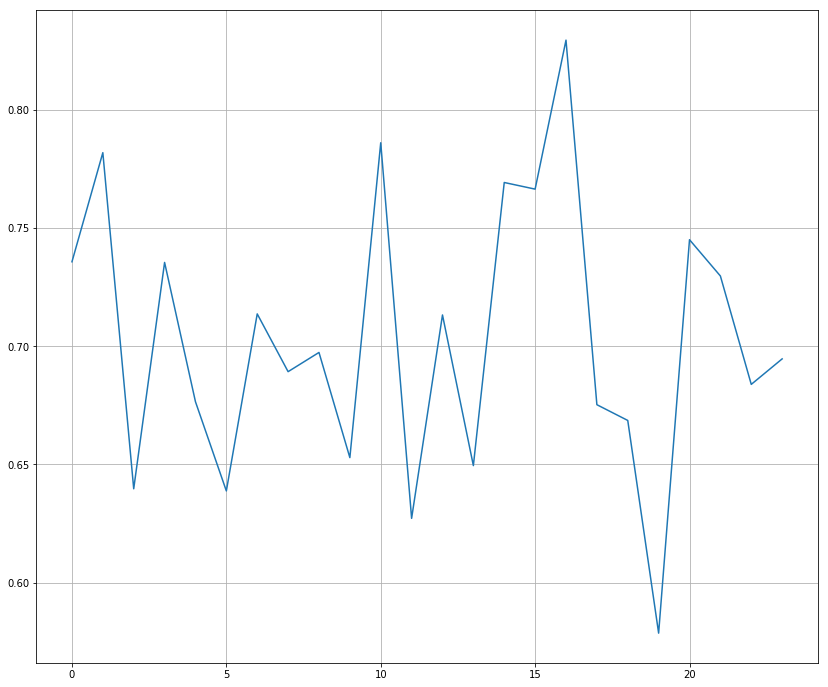

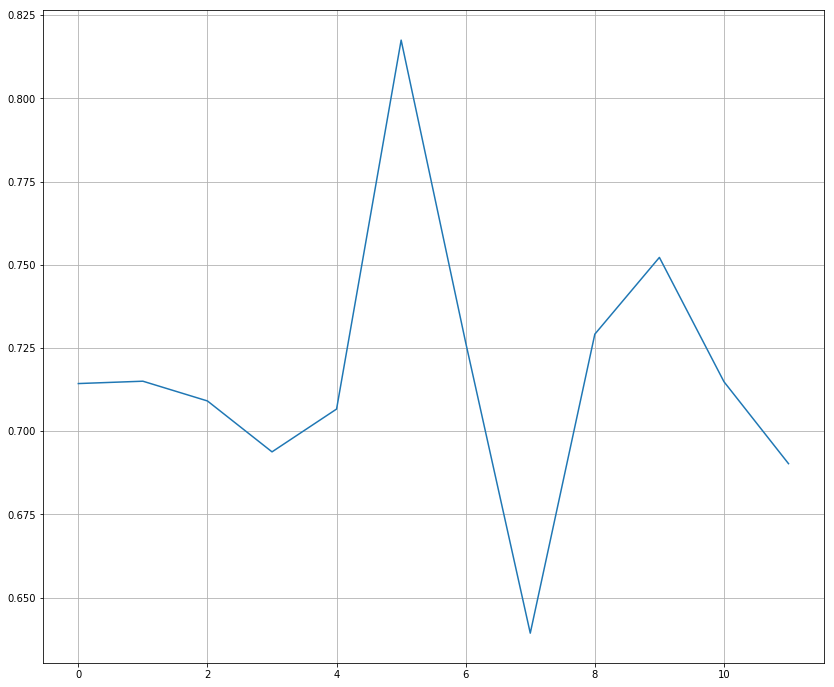

In [38]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['loss'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['loss'])
plt.grid()

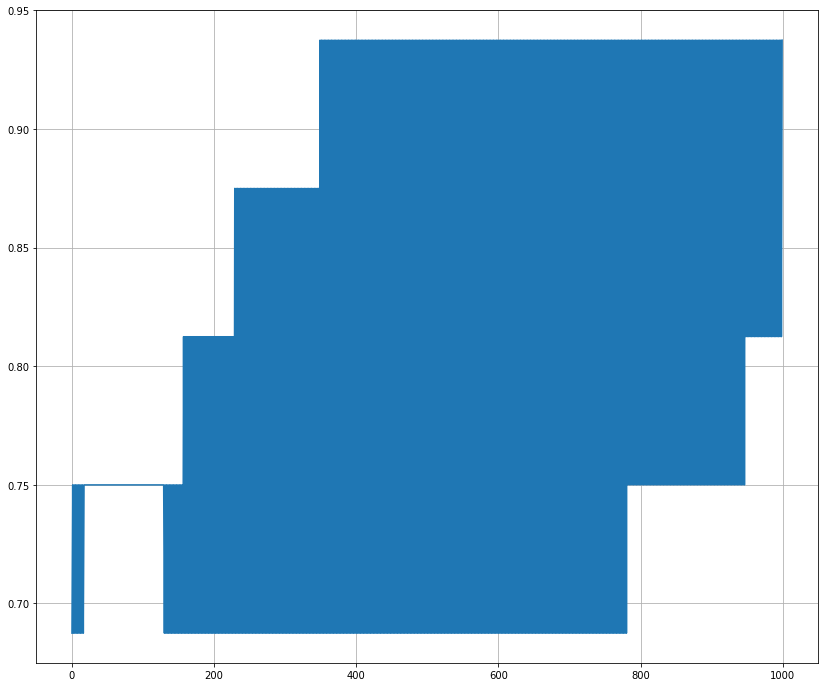

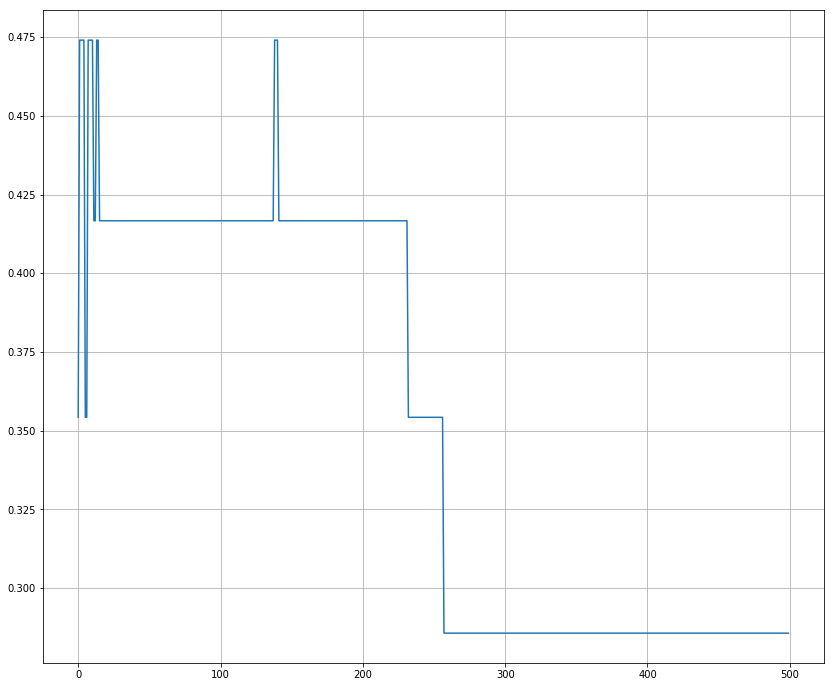

In [58]:
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['f1'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['f1'])
plt.grid()

In [70]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          